In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import pyhf
import eos
import matplotlib.pyplot as plt
from publik import modifier
from publik import plot
from pilnu_utils import * 

In [8]:
fitbins = np.linspace( 3.40, 26.41, 8).tolist()
q2bins = np.linspace(  3.40, 26.41, 6).tolist()
ctbins = np.linspace( -1.00,  1.00, 5).tolist()
binning = [q2bins, ctbins]

In [9]:
p = eos.Parameters()
o = eos.Options({'form-factors': 'BSZ2015', 'l': 'tau', 'model':'WET'})
k = eos.Kinematics({
    'q2':            5.0,  'q2_min':            3.4,     'q2_max':           26.41,
    'cos(theta_l)':  0.0,  'cos(theta_l)_min': -1.0,      'cos(theta_l)_max': +1.0,
})

pdf = eos.SignalPDF.make('B->pilnu::d^2Gamma/dq2/dcos(theta_l)', p, k, o)

null_samples, pdf_values = pdf.sample_mcmc(50000, stride=5, pre_N=10000, preruns=5, cov_scale=0.1, rng=np.random.mtrand.RandomState(seed=1234))

In [10]:
min(null_samples[:,0])

3.4227119911917177

In [11]:
mb = 5.279
mt = 1.777
mp = 0.135

(mb-mp)**2 - (mb-mp-mt)**2

15.124047000000001

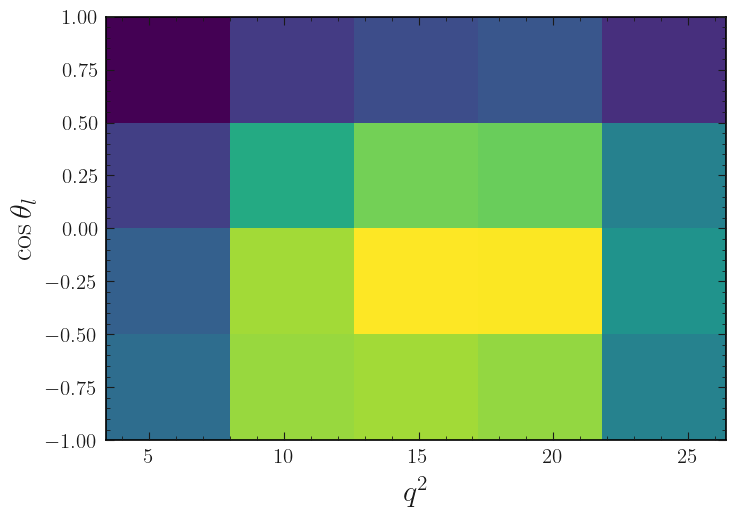

In [12]:
plt.hist2d(null_samples[:,0], null_samples[:,1], binning)
plt.xlabel(r'$q^2$')
plt.ylabel(r'$\cos\theta_l$')
plt.show()

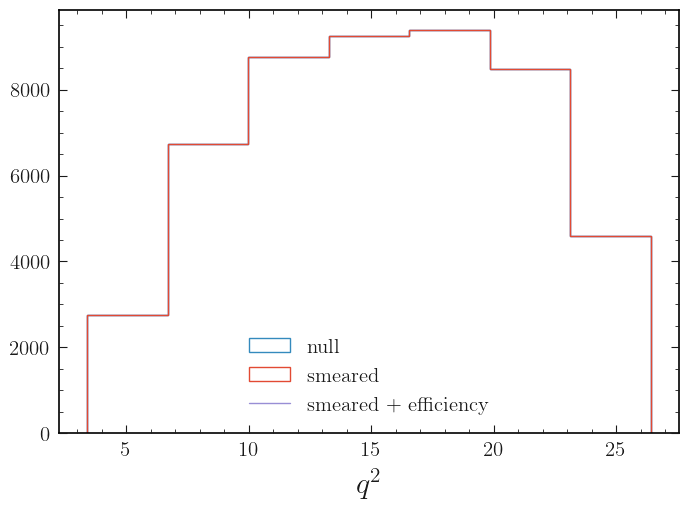

In [13]:
plt.hist(null_samples[:,0], fitbins, histtype='step', label='null')
null_yields, _, _ = plt.hist(null_samples[:,0], fitbins, histtype='step', label='smeared')
# null_yields *= efficiency(bin_cents)
plt.stairs(null_yields, fitbins, label='smeared + efficiency')
plt.xlabel(r'$q^2$')
plt.legend()

## Get covariance matrix of hadronic parameters

In [14]:
null = null_pred()
alt = alt_pred()

In [15]:
cov = parameter_cov(alt.ana)
pd.DataFrame(cov).style.background_gradient(cmap='RdBu')

Pre-runs:   0%|          | 0/5 [00:00<?, ?it/s]

,0,1,2,3,4
0,0.000149,0.001617,0.000967,0.002715,0.011957
1,0.001617,0.033203,0.146104,0.038435,0.204480
2,0.000967,0.146104,1.712060,0.075982,0.845943
3,0.002715,0.038435,0.075982,0.060394,0.305107
4,0.011957,0.204480,0.845943,0.305107,2.129121


In [16]:
mapping_dist = np.histogramdd([null_samples[:,0], null_samples[:,0], null_samples[:,1]], bins=[fitbins, q2bins, ctbins])[0]
mapping_dist

array([[[1032.,  870.,  612.,  243.],
        [   0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.]],

       [[ 793.,  758.,  558.,  209.],
        [1446., 1495., 1077.,  413.],
        [   0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.]],

       [[   0.,    0.,    0.,    0.],
        [2266., 2277., 1717.,  704.],
        [ 528.,  602.,  503.,  169.],
        [   0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.]],

       [[   0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.],
        [2706., 3090., 2520.,  942.],
        [   0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.]],

       [[   0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.],
        [ 551.,  623.,  476.,  239.],
        [2176., 2467., 1995.,  870.],
        [   0.,    0.,    0.,    0.]],

       [[   0.,    0.,    0.,    0.],
  

In [17]:
null.distribution(q2bins, ctbins)

array([[7.76800248e-04, 2.66872608e-02, 2.88697636e-02, 2.70676080e-02,
        2.25454519e-02, 6.53382430e-04],
       [5.93651985e-04, 2.72861958e-02, 3.59321158e-02, 3.79267209e-02,
        3.24322707e-02, 6.31632347e-04],
       [4.03142956e-04, 2.30412734e-02, 3.34930857e-02, 3.70990096e-02,
        3.21496102e-02, 6.04135967e-04],
       [2.05273161e-04, 1.39524935e-02, 2.15526735e-02, 2.45844743e-02,
        2.16974703e-02, 5.70893289e-04],
       [4.25983947e-08, 1.98561427e-05, 1.10879009e-04, 3.83114826e-04,
        1.07585099e-03, 5.31904314e-04]])

In [18]:
x = np.linspace(min(q2bins), max(q2bins), 100)
y = np.linspace(min(ctbins), max(ctbins), 100)
X,Y = np.meshgrid(x, y) # grid of point
Z = null.distribution(x, y) # evaluation of the function on the grid
Z_bin = modifier.bintegrate(null.distribution, binning)

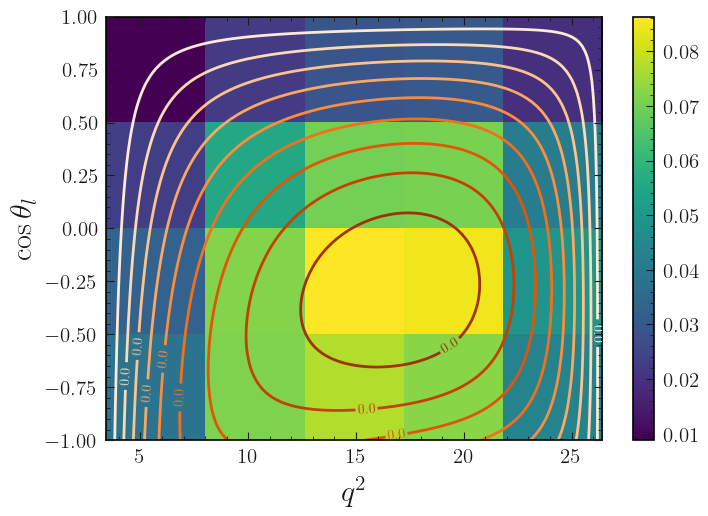

In [19]:
extent = [min(x),max(x),min(y),max(y)]
# clevels = np.linspace(-60, -55, 10)

im = plt.imshow(Z_bin, cmap='viridis', extent=extent, interpolation=None, origin='lower', aspect='auto') 
cset = plt.contour(X,Y,Z, 10, linewidths=2, cmap='Oranges', extent=extent)
plt.clabel(cset,inline=True,fmt='%1.1f',fontsize=10)
plt.colorbar(im)
plt.xlabel(r'$q^2$')
plt.ylabel(r'$\cos\theta_l$')
plt.show()

In [20]:
ana = analysis()
cvl = ana.parameters['cbtaunutau::Re{cVL}'     ].evaluate()
csl = ana.parameters['cbtaunutau::Re{cSL}'     ].evaluate()
ct  = ana.parameters['cbtaunutau::Re{cT}'      ].evaluate()
fp0 = ana.parameters['B->D::alpha^f+_0@BSZ2015'].evaluate()
fp1 = ana.parameters['B->D::alpha^f+_1@BSZ2015'].evaluate()
fp2 = ana.parameters['B->D::alpha^f+_2@BSZ2015'].evaluate()
f01 = ana.parameters['B->D::alpha^f0_1@BSZ2015'].evaluate()
f02 = ana.parameters['B->D::alpha^f0_2@BSZ2015'].evaluate()

In [21]:
alt.distribution(q2bins, ctbins, cvl, csl, ct, fp0, fp1, fp2, f01, f02)

array([[7.76800248e-04, 2.66872608e-02, 2.88697636e-02, 2.70676080e-02,
        2.25454519e-02, 6.53382430e-04],
       [5.93651985e-04, 2.72861958e-02, 3.59321158e-02, 3.79267209e-02,
        3.24322707e-02, 6.31632347e-04],
       [4.03142956e-04, 2.30412734e-02, 3.34930857e-02, 3.70990096e-02,
        3.21496102e-02, 6.04135967e-04],
       [2.05273161e-04, 1.39524935e-02, 2.15526735e-02, 2.45844743e-02,
        2.16974703e-02, 5.70893289e-04],
       [4.25983947e-08, 1.98561427e-05, 1.10879009e-04, 3.83114826e-04,
        1.07585099e-03, 5.31904314e-04]])

In [22]:
cvl = 1.
csl = 0.5
ct  = -0.5
Z = alt.distribution(x, y, cvl, csl, ct, fp0, fp1, fp2, f01, f02) # evaluation of the function on the grid
Z_bin = modifier.bintegrate(alt.distribution, binning, args=(cvl, csl, ct, fp0, fp1, fp2, f01, f02))

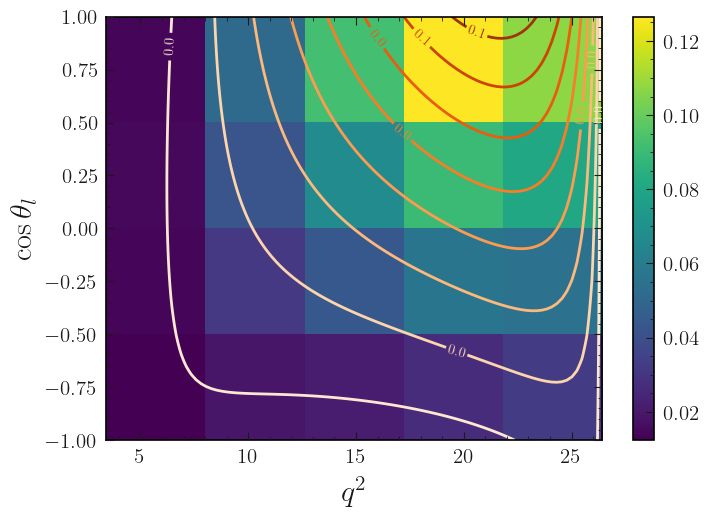

In [23]:
extent = [min(x),max(x),min(y),max(y)]

im = plt.imshow(Z_bin, cmap='viridis', extent=extent, interpolation=None, origin='lower', aspect='auto') 
cset = plt.contour(X,Y,Z, 10, linewidths=2, cmap='Oranges', extent=extent)
plt.clabel(cset,inline=True,fmt='%1.1f',fontsize=10)
plt.colorbar(im)
plt.xlabel(r'$q^2$')
plt.ylabel(r'$\cos\theta_l$')
plt.show()

## Set up the custom modifier

In [24]:
# TODO Why do I have to initialize csl and ctl to > 0. for the fit to work properly?
new_params = {
                'cvl'   :{'inits': (1.0,), 'bounds': ((-2., 2.),), 'paramset_type': 'unconstrained'},
                'csl'   :{'inits': (0.1,), 'bounds': ((-2., 2.),), 'paramset_type': 'unconstrained'},
                'ct '   :{'inits': (0.1,), 'bounds': ((-2., 2.),), 'paramset_type': 'unconstrained'},
                'FF'    :{'inits': (fp0, fp1, fp2, f01, f02), 
                         'bounds': (), 
                         'cov': cov, 
                         'paramset_type': 'constrained_by_normal'}
            }

cmod = modifier.Modifier(new_params, alt.distribution, null.distribution, mapping_dist, [q2bins, ctbins])
cmod.expanded_pyhf

{'custom': (publik.custom_modifier.add.<locals>._builder,
  publik.custom_modifier.add.<locals>._applier),
 'histosys': (pyhf.modifiers.histosys.histosys_builder,
  pyhf.modifiers.histosys.histosys_combined),
 'lumi': (pyhf.modifiers.lumi.lumi_builder, pyhf.modifiers.lumi.lumi_combined),
 'normfactor': (pyhf.modifiers.normfactor.normfactor_builder,
  pyhf.modifiers.normfactor.normfactor_combined),
 'normsys': (pyhf.modifiers.normsys.normsys_builder,
  pyhf.modifiers.normsys.normsys_combined),
 'shapefactor': (pyhf.modifiers.shapefactor.shapefactor_builder,
  pyhf.modifiers.shapefactor.shapefactor_combined),
 'shapesys': (pyhf.modifiers.shapesys.shapesys_builder,
  pyhf.modifiers.shapesys.shapesys_combined),
 'staterror': (pyhf.modifiers.staterror.staterror_builder,
  pyhf.modifiers.staterror.staterror_combined)}

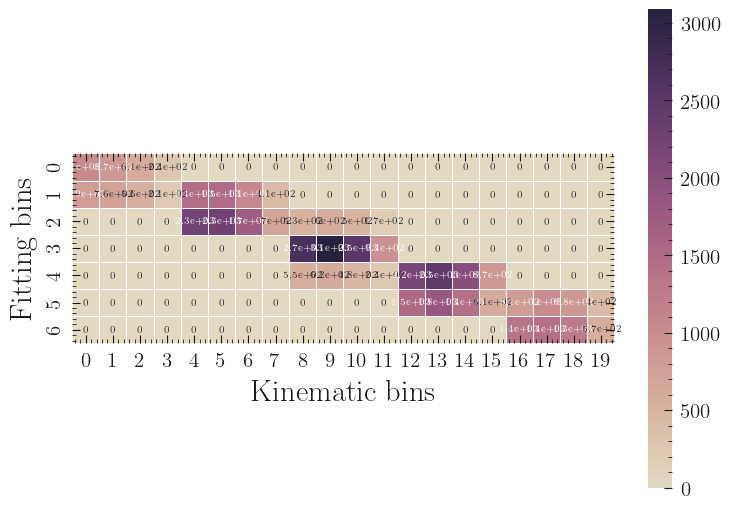

In [25]:
plot.map(cmod)

In [57]:
spec = {
  "channels": [
    {
      "name": "singlechannel",
      "samples": [
        {
          "name": "signal",
          "data": null_yields.tolist(),
          "modifiers": [
            {
                "name": "mu",
                "type": "normfactor",
                "data": None
            },
            {
                "name": "stat",
                "type": "staterror",
                "data": np.sqrt(null_yields).tolist()
            }
          ]
        },
      ]
    }
  ]
}
model = pyhf.Model(spec)

custom_mod = {
                "name": "theory",
                "type": "custom",
                "data":
                    {
                        "expr": "weight_function",
                        "ibin": [i for i in range(len(fitbins)-1)],
                    }
              }

model = modifier.add_to_model(model, ['singlechannel'], ['signal'], cmod.expanded_pyhf, custom_mod)
model.spec

{'channels': [{'name': 'singlechannel',
   'samples': [{'name': 'signal',
     'data': [50.0, 4366.0, 8564.0, 10329.0, 11054.0, 9886.0, 5751.0],
     'modifiers': [{'name': 'mu', 'type': 'normfactor', 'data': None},
      {'name': 'stat',
       'type': 'staterror',
       'data': [7.0710678118654755,
        66.07571414672717,
        92.5418824100742,
        101.63168797181321,
        105.13800454640558,
        99.42836617384397,
        75.83534795858722]},
      {'name': 'theory',
       'type': 'custom',
       'data': {'expr': 'weight_function',
        'ibin': [0, 1, 2, 3, 4, 5, 6]}}]}]}]}

In [58]:
model.config.par_map

{'cvl': {'slice': slice(0, 1, None),
  'paramset': <pyhf.parameters.paramsets.unconstrained at 0x14eea7cb8e50>},
 'csl': {'slice': slice(1, 2, None),
  'paramset': <pyhf.parameters.paramsets.unconstrained at 0x14eea7cb8940>},
 'ct ': {'slice': slice(2, 3, None),
  'paramset': <pyhf.parameters.paramsets.unconstrained at 0x14eea7cb8bb0>},
 'FF_decorrelated[0]': {'slice': slice(3, 4, None),
  'paramset': <pyhf.parameters.paramsets.constrained_by_normal at 0x14eea7cb88e0>},
 'FF_decorrelated[1]': {'slice': slice(4, 5, None),
  'paramset': <pyhf.parameters.paramsets.constrained_by_normal at 0x14eea7cb8ac0>},
 'FF_decorrelated[2]': {'slice': slice(5, 6, None),
  'paramset': <pyhf.parameters.paramsets.constrained_by_normal at 0x14eea7cb8a60>},
 'FF_decorrelated[3]': {'slice': slice(6, 7, None),
  'paramset': <pyhf.parameters.paramsets.constrained_by_normal at 0x14eea7cb8af0>},
 'FF_decorrelated[4]': {'slice': slice(7, 8, None),
  'paramset': <pyhf.parameters.paramsets.constrained_by_normal at

## Generate some fake data

Alternative yields 
 [1.67241657e+01 2.12756167e+03 4.90153781e+03 7.90495808e+03
 1.30809141e+04 1.96772770e+04 1.83405372e+04]


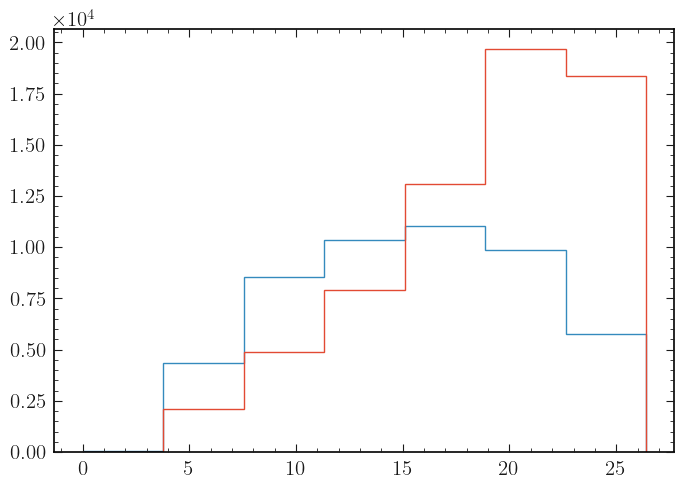

In [59]:
init = model.config.suggested_init()
init[0] =  1.0 # cvl
init[1] =  0.5 # csl
init[2] = -0.5 # ctl
alt_yields = model.expected_actualdata(init)

print('Alternative yields \n', alt_yields)

plt.stairs(null_yields, fitbins)
plt.stairs(alt_yields, fitbins)

In [60]:
#Save and load model
modifier.save('pilnu_model.json', model.spec, cmod, alt_yields)
model, alt_yields = modifier.load('pilnu_model.json', alt.distribution, null.distribution, return_data=True)

data = alt_yields + model.config.auxdata

## Perform the fit

In [61]:
fixed = model.config.suggested_fixed()
fixed[model.config.par_map['mu']['slice']] = [True]

pyhf.set_backend("numpy", pyhf.optimize.scipy_optimizer())
best_fit = pyhf.infer.mle.fit(data, model, fixed_params=fixed)
# pyhf.set_backend("numpy", pyhf.optimize.minuit_optimizer(verbose=True, strategy=2))
# best_fit, twice_nll, OptimizeResult = pyhf.infer.mle.fit(
#     data,
#     model,
#     fixed_params=fixed,
#     return_uncertainties=True,
#     return_fitted_val=True,
#     return_result_obj=True
#     )

best_fit_dict = modifier.par_dict(model, best_fit)
best_fit_dict


KeyboardInterrupt: 

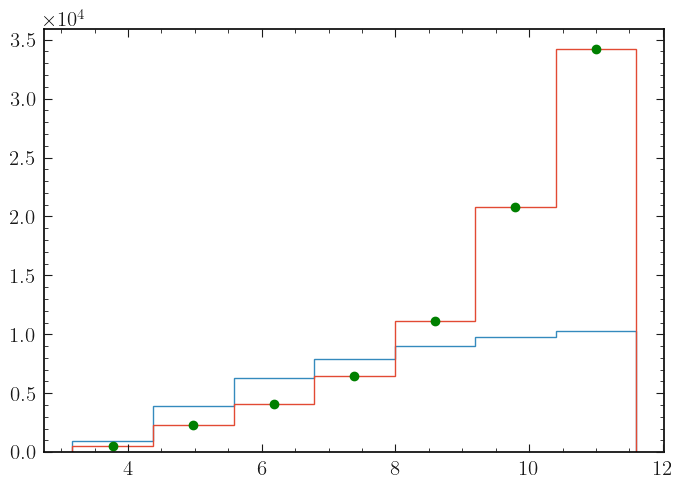

In [ ]:
plt.stairs(model.expected_actualdata(model.config.suggested_init()), fitbins)
plt.stairs(model.expected_actualdata(best_fit), fitbins)
bin_cents = (np.array(fitbins)[:-1] + np.array(fitbins)[1:])/2
plt.plot(bin_cents, alt_yields, 'og')